# Проводим АБ тест для анализа эксперимента
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
# Задачи:

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.м.


In [2]:
#Получаем данные и смотрим на размер групп

import pandahouse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
                    'database':'simulator_20220520',
                    'user':'student', 
                    'password':'dpo_python_2020'
}

q = '''SELECT user_id, 
            exp_group,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM {db}.feed_actions
        where toDate(time) >= '2022-04-24' and toDate(time) <= '2022-04-30' and exp_group in (2,1)
        group by user_id, exp_group
        '''

df = pandahouse.read_clickhouse(q, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


<AxesSubplot:xlabel='ctr', ylabel='Count'>

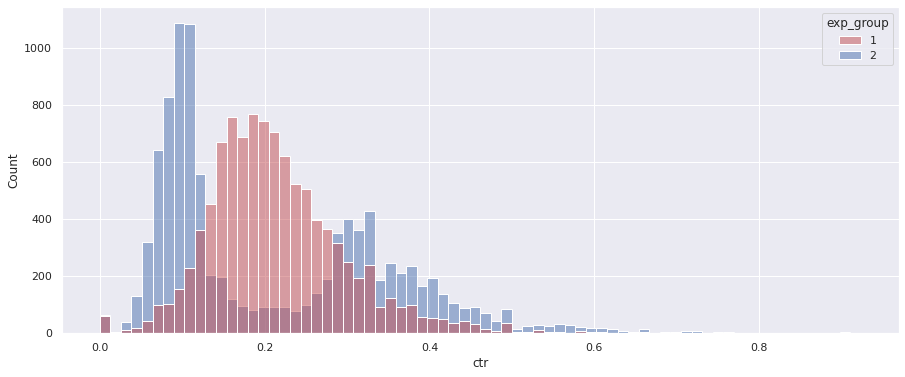

In [3]:
#Построим график
sns.set(rc = {'figure.figsize':(15,6)})
sns.histplot(data = df, x = 'ctr', hue = 'exp_group', palette = ['r', 'b'], alpha = 0.5, kde = False)

По графику видно, что в тестовой группе (2-я) видно как улучшение, так и ухудшение CTR, по странению с контрольной, причём ухудшение доменирует. Проверим это тестами.

In [62]:
#проводим t-тест
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var = False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

По обычному t тесту видим, что p_value = 0,47. Тут t тест не показал статистически значимых различий, p value получился довольно высокий. Причин отклонить нулевую гипотезу у нас нет.

In [5]:
#проводим тест Манна Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна Уитни показал весьма малое P value, что говорит о статистически значимых различиях. Пока неоднозначно, продолжим исследовать наши данные, надо узнать изменилась ли метрика, по сравнению с контрольной группой.

# t-тест на сглаженном CTR

In [6]:
#Построим фенкцию, которая будет сглаживать наш CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [7]:
#Возьмём глобальный CTR по каждой из групп
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [8]:
#Выделим данные из датафрейма только с нашими группами
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

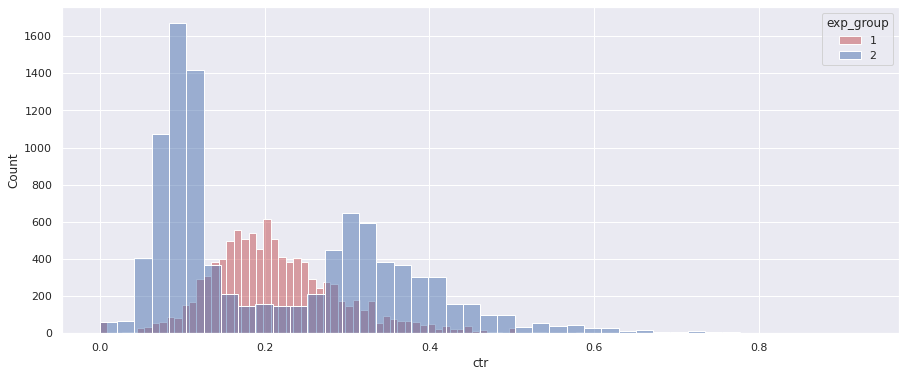

In [57]:
#Построим график распределения без сглаживания
sns.histplot(group1.ctr, kde = False, color = 'r', label = '1', alpha=0.5)
sns.histplot(group2.ctr, kde = False, color = 'b', label = '2', alpha=0.5)
plt.legend(title = 'exp_group')

In [10]:
#Добавим столбец со сглаживанием CTR
group1['smothead_ctr'] = group1.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1)
group2['smothead_ctr'] = group2.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis = 1)

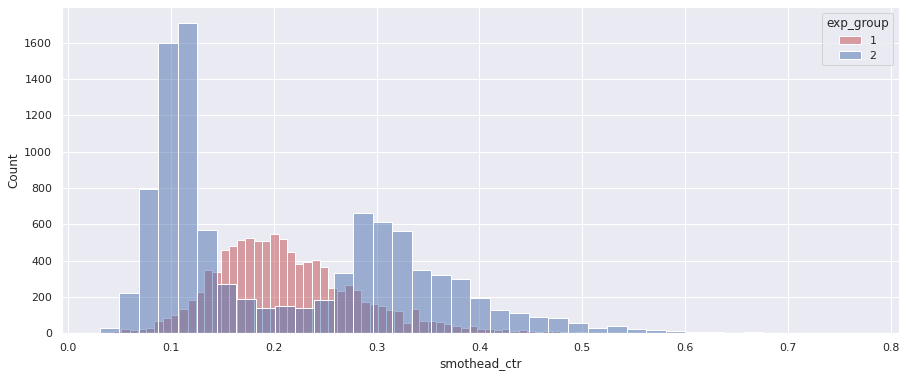

In [56]:
#Построим график после сглаживания
sns.histplot(group1.smothead_ctr, kde = False, color = 'r', label = '1', alpha=0.5)
sns.histplot(group2.smothead_ctr, kde = False, color = 'b', label = '2', alpha=0.5)
plt.legend(title = 'exp_group')

In [12]:
#t-тест на сглаженном CTR
stats.ttest_ind(group1.smothead_ctr,
                group2.smothead_ctr,
                equal_var = False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

На сглаженном CTR мы получили статистически значимые различи и видим, что сам тест стал более чувствительный. Также сам грфик стал выглядеть более сглаженным.

# Пуассоновский бутстреп 

In [13]:
#Пишем функцию, для подсчёта разницы в CTR и повторяем процедуру 2000 раз

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [14]:
#Переводим данные по лайкам и просмотрам в массив

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [15]:
#Прогоняем данные через функцию
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

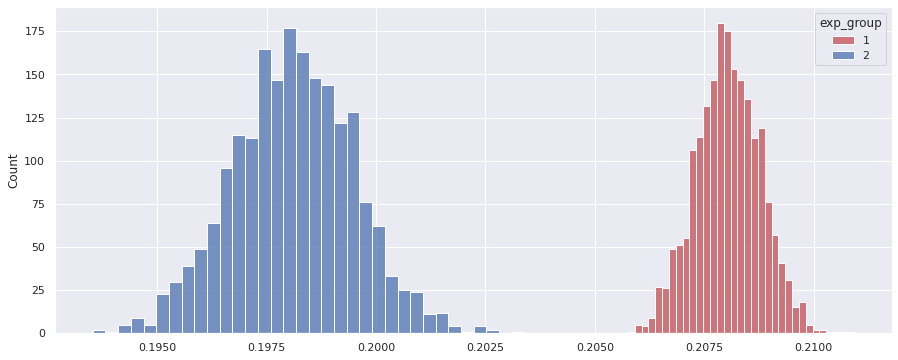

In [24]:
#Строим график, чтобы посмотреть разность CTR между двумя группами
#Напомню, что 1 группа у нас контрольная, а вторая тестовая
sns.histplot(ctr1, color = 'r', label = '1')
sns.histplot(ctr2, color = 'b', label = '2')
plt.legend(title = 'exp_group')

<AxesSubplot:ylabel='Count'>

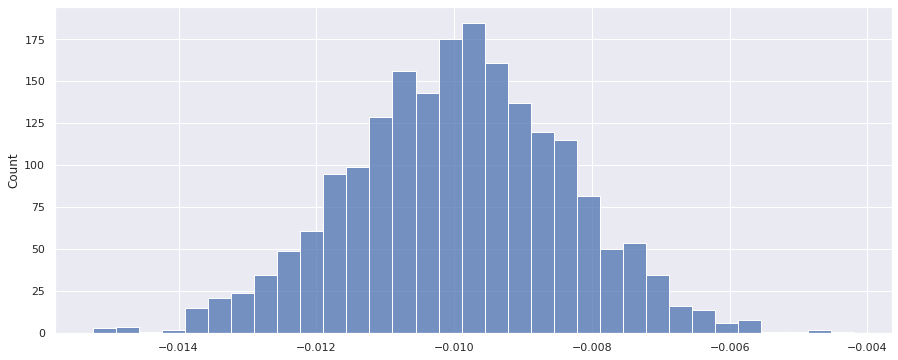

In [25]:
#Смотрим разницу CTR между тестовой и контрольной группой
sns.histplot(ctr2 - ctr1)

Как видно на первом и втором графике, СTR в контрольной группе оказался выше, чем в тестовой. На втором графике видно, что разница между тестовой и контрольной группой не пересекается и лежит по одну строну от нуля. Данный тест показал, что новая рекомендация постов отрабола хуже, чем та, которая уже используется.

# Бакетное преобразование


In [43]:
#Получаем данные для бакетного преобразования. Делим наших пользователей на группы по 50 человек.

q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_b = pandahouse.read_clickhouse(q, connection=connection)
df_b.head(2)

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262


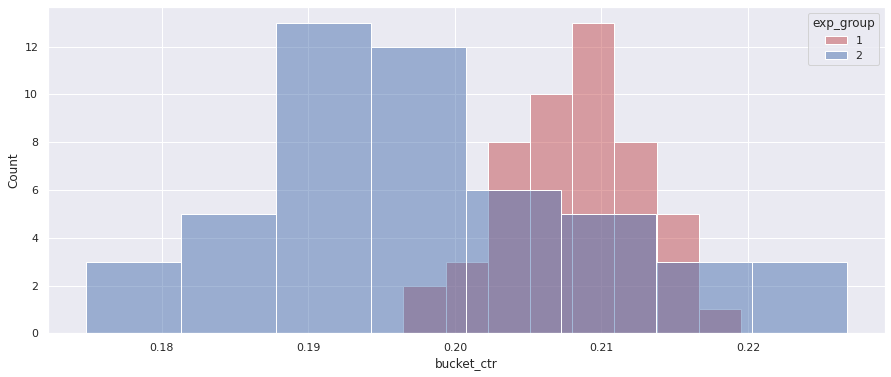

In [58]:
#Визуализируем даннные
sns.histplot(df_b[df_b.exp_group == 1].bucket_ctr, color = 'r', label = '1', alpha=0.5)
sns.histplot(df_b[df_b.exp_group == 2].bucket_ctr, color = 'b', label = '2', alpha=0.5)
plt.legend(title = 'exp_group')

In [47]:
#Проводим t-тест
stats.ttest_ind(df_b[df_b.exp_group == 1].bucket_ctr, 
                   df_b[df_b.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [46]:
#Проводим тест Манна Уитни
stats.mannwhitneyu(df_b[df_b.exp_group == 1].bucket_ctr, 
                   df_b[df_b.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

# Выводы

Соберём все данные по результатам тестов:
-    t-тест:           p-value = 0.4780623130874935
-    Тест Манна-Уитни: p-value = 6.0376484617779035e-56
-    Пуассоновский бутстреп: Тестовая группа показала результаты хуже, чем контрольная. 
-    t-тест на сглаженном ctr: p-value = 0.0223769815558559
-    t-тест и тест Манна-Уитни поверх бакетного преобразования:  t-тест (p-value = 3.4455951649945907e-07),  тест Манна-Уитни (p-value = 2.859963936492646e-07)

По графику, который мы построили с самого начала видно, что тестовая группа имеет бимодальное распределение. Это говорит о том, что система отработала неоднозначно, каким-то пользователям был интересен контент, каким-то нет. Но на визуальзации видно, что доминируещее количество наблюдений находится на более низком CTR, чем в контрольной группе.

Что собственно подтверждают наши тесты, они все (кроме t-теста на исходных данных) показали статистическую значимость в ухудшении CTR. Лучше всего нам показывает это пуассоновский бутстреп, на нём чётко видна разность CTR в тестовой и котнтрольной группе в пользу контрольной группы.

В итоге можем сделать вывод, что новая сисема рекомендации постов показала плохие результат и использовать её в таком виде не рекомендуется. Возможно следует доработать её и испытать заново.

Одно из предположений, почему новый алгоритм не сработал заключается в том, что вероятно сам алгоритм не совсем корректно предлагал посты, на основе лайков пользователя и возможно они были не совсем релевантны для данного человека.